[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/AlphaLabsUY/recsys/master)

[![Colab](https://camo.githubusercontent.com/52feade06f2fecbf006889a904d221e6a730c194/68747470733a2f2f636f6c61622e72657365617263682e676f6f676c652e636f6d2f6173736574732f636f6c61622d62616467652e737667
)](https://colab.research.google.com/github/AlphaLabsUY/recsys/blob/blog-notebook/recommendation_system_instacart.ipynb?authuser=1)


In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install implicit umap-learn -q

In [2]:
import os

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from umap import UMAP
from scipy.sparse import csr_matrix

os.environ["OPENBLAS_NUM_THREADS"] = "1"

# Get and load Data Set
The original datata set is provided by the followin kaggle competition [instacart market basket analysis](https://www.kaggle.com/c/instacart-market-basket-analysis/overview) 


In [3]:
!mkdir data
!if [ ! -f data/instacart.zip ]; then wget -O data/instacart.zip -q https://www.dropbox.com/s/p2w4hql4qjsm0a2/instacart.zip?dl=1; fi
!unzip -o data/instacart.zip -d data

mkdir: cannot create directory ‘data’: File exists
Archive:  data/instacart.zip
  inflating: data/aisles.csv         
  inflating: data/departments.csv    
  inflating: data/order_products__prior.csv  
  inflating: data/order_products__train.csv  
  inflating: data/orders.csv         
  inflating: data/products.csv       
  inflating: data/sample_submission.csv  


In [4]:
dataset_path = "./data/" 

orders_path = os.path.join(dataset_path, "orders.csv")
product_path = os.path.join(dataset_path, "products.csv")
orders_product_prior_path = os.path.join(dataset_path, "order_products__prior.csv")
orders_product_train_path = os.path.join(dataset_path, "order_products__train.csv")
departments_path = os.path.join(dataset_path, "departments.csv")

In [5]:
orders = pd.read_csv(orders_path)
products = pd.read_csv(product_path)
orders_product_prior = pd.read_csv(orders_product_prior_path)
orders_product_train = pd.read_csv(orders_product_train_path)
departments = pd.read_csv(departments_path)

In [6]:
products.set_index('product_id', inplace=True)

# Exploratory Data Analysis

## Products

In [7]:
products.shape

(49688, 3)

In [8]:
products.head()

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13


In [9]:
products['department_id'].value_counts().plot(kind='bar')

<AxesSubplot:>

## Orders


In [10]:
orders.shape

(3421083, 7)

In [11]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [12]:
orders.shape

(3421083, 7)

In [13]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

## Users

In [14]:
orders["user_id"].nunique()

206209

In [15]:
orders["eval_set"].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

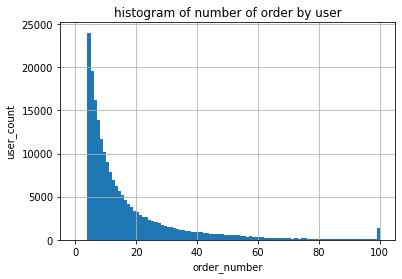

In [16]:
ax = orders.groupby("user_id")['order_number'].max().hist(bins=100, range=(0,100))
ax.set(xlabel='order_number', ylabel='user_count', title='histogram of number of order by user');


In [17]:
orders_prior = orders[orders["eval_set"] == "prior"]

orders_train = orders[orders["eval_set"] == "train"]

print(f'Number of unique user in prior: {len(orders_prior["user_id"].unique())}')
print(f'Number of unique user in train: {len(orders_train["user_id"].unique())}')

Number of unique user in prior: 206209
Number of unique user in train: 131209


## Order/Product

In [18]:
orders_product_prior.shape

(32434489, 4)

In [19]:
orders_product_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


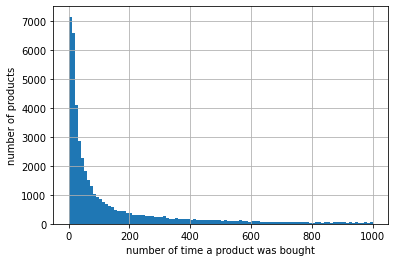

In [20]:
ax = (
    orders_product_prior['product_id']
    .value_counts()
    .hist(bins=100, range=(0,1000))
)
ax.set(xlabel='number of time a product was bought',
       ylabel='number of products');

# Feature Engineering


In [21]:
orders_prior = orders[orders["eval_set"] == "prior"]
orders_train = orders[orders["eval_set"] == "train"]

print(f'Number of unique user in prior: {len(orders_prior["user_id"].unique())}')
print(f'Number of unique user in train: {len(orders_train["user_id"].unique())}')

Number of unique user in prior: 206209
Number of unique user in train: 131209


In [22]:
users = orders_prior['user_id'].unique()

Get full list of user_id / product_id

In [23]:
user_product_prior = (
    orders_product_prior[['order_id', 'product_id']]
    .merge(orders[['user_id', 'order_id']], on='order_id')
    .drop(columns=['order_id'])
)

user_product_train = (
    orders_product_train[['order_id', 'product_id']]
    .merge(orders[['user_id', 'order_id']], on='order_id')
    .drop(columns=['order_id'])
)

In [24]:
user_product_prior.shape

(32434489, 2)

In [25]:
user_product_train.shape

(1384617, 2)

In [26]:
class SparseTransformer:
    """Convert user-item dataset into a sparse matrix"""
    def __init__(self):
        self.users = None
        self.products = None
        self.shape = None
    
    def _sparse_matrices(self, users, products):
        alpha = 1
        values = [alpha] * len(users)
        row_index = users
        col_index = products

        sparse_user_item = \
            csr_matrix((values, (row_index, col_index)), shape=self.shape)
    
        return sparse_user_item

    def fit(self, users, products):
        self.shape = (np.max(users) + 1, np.max(products) + 1)
        return self
    
    def transform(self, users, products):
        return self._sparse_matrices(users, products)
    
    def fit_transform(self, users, products):
        return self.fit(users, products).transform(users, products)

In [27]:
data_model = SparseTransformer().fit(users=user_product_prior['user_id'],
                                     products=user_product_prior['product_id'])

sparse_user_item_prior = data_model.transform(user_product_prior['user_id'],
                                              user_product_prior['product_id'])
sparse_user_item_prior = (bm25_weight(sparse_user_item_prior, B=0.9) * 5).tocsr()
sparse_item_user_prior = sparse_user_item_prior.T.tocsr()


sparse_user_item_prior.shape

(206210, 49689)

# Modeling

## Random Model (base line)

In [28]:
class RandomModel():
    def __init__(self):
        self.products = None
    
    def train(self, products):
        self.products = np.asarray(products)
        return self

    def recommend(self, size=(1,10)):
        return np.random.choice(self.products, size=size, replace=False)

In [29]:
random_model = RandomModel().train(products.index.tolist())

## Alternating Least Squares (ALS) model

In [30]:
model_user_item = AlternatingLeastSquares(factors=128,
                                          random_state=42,
                                          iterations=10,
                                          calculate_training_loss=True,
                                         )
model_user_item.fit(item_users=sparse_item_user_prior)

  0%|          | 0/10 [00:00<?, ?it/s]

# Evaluation

## Random Model

In [31]:
random_rec = random_model.recommend()

products.loc[random_rec[0].tolist(), :]

,product_name,aisle_id,department_id
product_id,,,
1103,Hickory Smoked Turkey Breast,96,20
28986,Mild Italian Chicken Sausage,106,12
23153,Lean Fare Chicken Tikka Masala,38,1
41791,Brie Soft Ripened Cheese,21,16
37615,Veggie Pick Ups Diced Carrots,92,18
15209,Citrus Electrolyte Tabs,90,7
15795,Organic Sweet Potato (Yam),100,21
23899,Smart Menu Vegetable Meatball,13,20
39884,Calorie Free Pancake Syrup,29,13


## ALS Model

In [32]:
user_id = 12221

The following tabla show the most frequent products bought by the user_id

In [33]:
user_prod_freq = (
    user_product_prior
    .loc[user_product_prior['user_id'] == user_id, 'product_id']
    .value_counts()
    .iloc[:20]
)

products.loc[user_prod_freq.index.to_list(), :]

,product_name,aisle_id,department_id
product_id,,,
39275,Organic Blueberries,123,4
29142,Natural Chicken & Apple Breakfast Sausage Patty,52,1
1117,Turkey Bacon,106,12
18264,Bar Oat Chocolate,3,19
26209,Limes,24,4
3819,Organic Mocha Coffee Concentrate,26,7
28745,Oven Roasted Turkey,96,20
16797,Strawberries,24,4
20119,Sparkling Water Berry,115,7


### User recommendation

In [34]:
recommendation = model_user_item.recommend(user_id, sparse_user_item_prior, N=20)

products.loc[[k[0] for k in recommendation], :]

,product_name,aisle_id,department_id
product_id,,,
311,Naturals Savory Turkey Breakfast Sausage,52,1
47626,Large Lemon,24,4
35221,Lime Sparkling Water,115,7
47630,Medium Navel Orange,24,4
43504,Organic Chicken Strips,34,1
5450,Small Hass Avocado,24,4
48287,Natural Chicken & Maple Breakfast Sausage Patty,34,1
14947,Pure Sparkling Water,115,7
4658,Imported Mineral Water,115,7


### Explanation

In [35]:
product_id = 311
_, top_contribution, _ = model_user_item.explain(user_id, sparse_user_item_prior, product_id)
pd.DataFrame([(products.loc[product_id, 'product_name'], score) for product_id,score in top_contribution], columns=['product', 'score'])

,product,score
0,Natural Chicken & Apple Breakfast Sausage Patty,0.411718
1,Savory Turkey Breakfast Sausage Patties,0.259178
2,Turkey Bacon,0.134493
3,Ground Turkey Breast,0.131994
4,Organic Avocados,0.089872
5,Organic Blueberries,0.074408
6,Bar Oat Chocolate,0.073298
7,Organic Mocha Coffee Concentrate,0.070948
8,Oven Roasted Turkey,0.065875
9,Uncured Hickory Smoked Sunday Bacon,0.060620


### Similar items

In this first example the most similar item belong to the same dapertment_id without give any information about it.

In [36]:
item_id = 8277
similar_product = np.asarray(model_user_item.similar_items(item_id), dtype=int)

products.loc[similar_product[:, 0], :]

,product_name,aisle_id,department_id
product_id,,,
8277,Apple Honeycrisp Organic,24,4
30391,Organic Cucumber,83,4
47209,Organic Hass Avocado,24,4
10749,Organic Red Bell Pepper,83,4
8518,Organic Red Onion,83,4
5876,Organic Lemon,24,4
45066,Honeycrisp Apple,24,4
45007,Organic Zucchini,83,4
22935,Organic Yellow Onion,83,4


In the second example the the most similar items are lest intuitive and don't belong to the same department_id

In [37]:
item_id = 49686
similar_product = np.asarray(model_user_item.similar_items(item_id), dtype=int)

products.loc[similar_product[:, 0], :]

,product_name,aisle_id,department_id
product_id,,,
49686,Artisan Baguette,112,3
35154,Dried Northwest Mix Mushrooms,63,9
35479,Oregon Strawberry Preserves,88,13
43612,Herb Organic Oregano,16,4
3660,Tostones Plantain Patties,116,1
34513,Organic Snapped Bean Medley,83,4
2931,Sushi Chef Panko Bread Flakes,66,6
33126,Sesame Flatbread,112,3
47299,Yellowfin Tuna Steak,39,12


# Visualization

The following chart show the similarity between product using the item latent factors of the model

In [ ]:
reducer = UMAP(n_neighbors=10, metric="cosine", n_components=3)
embedding = reducer.fit_transform(model_user_item.item_factors[1:,:])

In [ ]:
fig = go.Figure(data=[go.Scatter3d(
        x=reducer.embedding_[:,0],
        y=reducer.embedding_[:,1],
        z=reducer.embedding_[:,2],
        hovertext=products['product_name'],
        mode='markers',
        marker=dict(
            size=3,
            color=products['department_id'],                
            opacity=1,
            line_width=0.05
        )
    )])
fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1000,height=700)
fig.layout.template = 'plotly_white'
fig.show()